<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_3_Bab_9_9_1_U_Net_untuk_Segmentasi_Semantik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.7 MB/s eta 0:00:00


In [ ]:
import cv2

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torch_snippets import *
from torch_snippets.torch_loader import Report

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Google Drive
# https://drive.google.com/file/d/1QJDrW1ihkfgLAhrbiWyiz4iG5m1b736O/view?usp=sharing

# pip install gdown
!gdown https://drive.google.com/uc?id=1QJDrW1ihkfgLAhrbiWyiz4iG5m1b736O

Downloading...
From (original): https://drive.google.com/uc?id=1QJDrW1ihkfgLAhrbiWyiz4iG5m1b736O
From (redirected): https://drive.google.com/uc?id=1QJDrW1ihkfgLAhrbiWyiz4iG5m1b736O&confirm=t&uuid=0a7a45e1-9e62-482e-ac06-8037435be758
To: /content/camvid-dataset.zip
100% 126M/126M [00:01<00:00, 124MB/s]


In [ ]:
!unzip -q camvid-dataset.zip

In [ ]:
!dir

annotations_prepped_test   camvid-dataset.zip	images_prepped_train
annotations_prepped_train  images_prepped_test	sample_data


In [ ]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [ ]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'images_prepped_{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        image = read(f'images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [ ]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

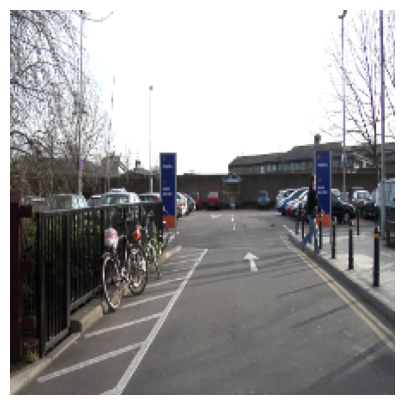

In [ ]:
show(trn_ds[10][0])

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
class UNet(nn.Module):
    def __init__(self, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(weights=VGG16_BN_Weights.DEFAULT).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)
        return x

In [ ]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 20

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 74.9MB/s]


In [ ]:
log = Report(n_epochs)

for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.803  trn_acc: 0.740  val_acc: 0.831  trn_loss: 1.159  (21.21s - 402.96s remaining)
EPOCH: 2.000  val_loss: 0.562  trn_acc: 0.832  val_acc: 0.864  trn_loss: 0.668  (39.07s - 351.65s remaining)
EPOCH: 3.000  val_loss: 0.622  trn_acc: 0.853  val_acc: 0.821  trn_loss: 0.555  (56.85s - 322.12s remaining)
EPOCH: 4.000  val_loss: 1.007  trn_acc: 0.864  val_acc: 0.682  trn_loss: 0.502  (74.35s - 297.39s remaining)
EPOCH: 5.000  val_loss: 0.485  trn_acc: 0.871  val_acc: 0.862  trn_loss: 0.467  (92.18s - 276.54s remaining)
EPOCH: 6.000  val_loss: 0.506  trn_acc: 0.882  val_acc: 0.851  trn_loss: 0.423  (110.00s - 256.67s remaining)
EPOCH: 7.000  val_loss: 0.587  trn_acc: 0.890  val_acc: 0.814  trn_loss: 0.389  (127.82s - 237.37s remaining)
EPOCH: 8.000  val_loss: 0.408  trn_acc: 0.887  val_acc: 0.872  trn_loss: 0.395  (146.05s - 219.07s remaining)
EPOCH: 9.000  val_loss: 0.374  trn_acc: 0.900  val_acc: 0.887  trn_loss: 0.349  (163.96s - 200.39s remaining)
EPOCH: 10.000  

100%|██████████| 121/121 [00:00<00:00, 2004.35it/s]


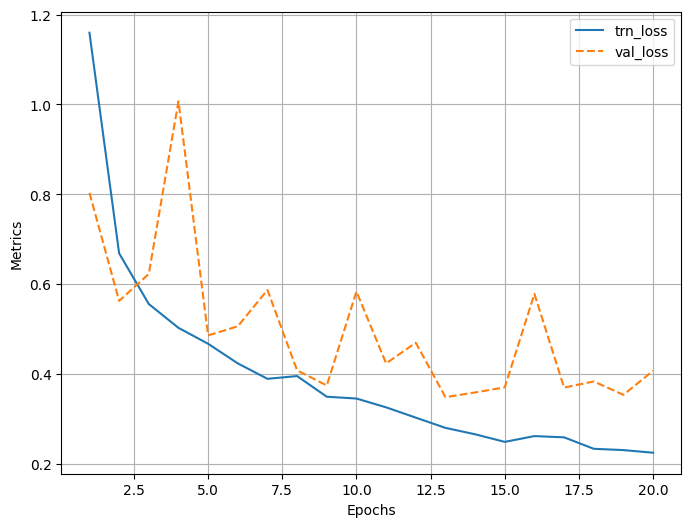

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

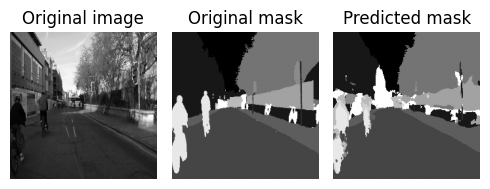

In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0],
          mask.permute(1,2,0).detach().cpu()[:,:,0],
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],
         nc=3,
         titles=['Original image', 'Original mask', 'Predicted mask'])